# A/B тестирование.

##### В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания нам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

##### Импортируем  необходимые библиотеки:

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency, chi2, chisquare
import numpy as np
import scipy.stats as ss
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Выгружаем данные

In [2]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv('Проект_2_active_studs.csv')

# файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

#файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('Проект_2_groups.csv', sep=';')

# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
add_group = pd.read_csv('Проект_2_group_add.csv')

##### Проверяем данные на наличие пропусков, дубликатов, смотрим размерность таблиц и типы данных, чтобы в случае необходимости привести их к нужному нам типу:

In [3]:
active_studs.shape

(8341, 1)

In [5]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
active_studs[active_studs.duplicated()]

,student_id


In [7]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [8]:
active_studs.dtypes

student_id    int64
dtype: object

In [9]:
checks.shape

(541, 2)

In [10]:
checks[checks.duplicated()]

,student_id,rev


In [11]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [12]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [13]:

groups.shape

(74484, 2)

In [14]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
groups.dtypes

id      int64
grp    object
dtype: object

In [16]:
groups[groups.duplicated ()]

,id,grp


In [17]:
add_group.shape

(92, 2)

In [18]:
add_group.isna().sum()

id     0
grp    0
dtype: int64

In [19]:
add_group.dtypes

id      int64
grp    object
dtype: object

In [20]:
add_group[add_group.duplicated ()]

,id,grp


#### Первым делом необходимо проверить корректно ли проведено сплитование на группы. Т.к. из информации о группах у нас есть только размер групп, то корректно провести проверку не получится. Поэтому, предположим, что сплитирование произведено верно и продолжим дальнейший анализ.

##### Для начала объединяем данные с группами в один датафрэйм и считаем количество пользователей в каждой группе

In [21]:
all_users = pd.concat([groups, add_group]).drop_duplicates()
all_users.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [22]:
# посчитала количество уникальных пользователей
all_users.id.nunique()

74576

In [23]:
df = all_users.groupby('grp', as_index=False)\
    .agg({'id':'nunique'})\
    .rename(columns={'id':'all_users'})
df

,grp,all_users
0,A,14693
1,B,59883


In [24]:
# считаем % пользователей в контрольной группе
round(14693/74576 * 100)

20

In [25]:
# считаем % пользователей в тестовой группе
round(59883/74576 * 100)

80

In [26]:
# проверяем сплитование с помощью х-квадрата
chisquare(df['all_users'])

Power_divergenceResult(statistic=27383.288189229777, pvalue=0.0)

#### Видим, что пользователей в тестовой группе на 60% больше, чем в контрольной. Так же, используя х-квадрат для проверки правильно ли разделены группы, получили  pvalue=0.0.Возможно это ошибка сплитования, но мы предположили, что сплитование разделено верно, т.к. в группах важно учитывать не только количество участников, но и такие параметры как, например, пол, возраст, платформу, регион и тп.

#### Дальше посчитаем активных пользователей в каждой группе и с помощью критерия хи-квадрат, мы можем проверить нулевую гипотезу о том, что пропорции активных пользователей равны пропорциям объема групп.

In [27]:
all_users = all_users.rename(columns={'id':'student_id'})

In [30]:
# соединили таблицу активных пользователей с данными обо всех студентов left join, тем самым отобрав только активных 
# студентов в каждой группе.
active_students = active_studs.merge(all_users, on='student_id', how='left').drop_duplicates()
active_students.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [31]:
# посчитали количество активных пользователей
count_active = active_students.groupby('grp', as_index = False)\
    .agg({'student_id':'count'})\
    .rename(columns=({'student_id': 'active_studs'}))
count_active

,grp,active_studs
0,A,1538
1,B,6803


In [32]:
round((1538/14693*100))

10

In [33]:
round((6803/59883*100))

11

In [34]:
# Используя критерий хи-квадрат, мы можем проверить нулевую гипотезу о том, что пропорции активных пользователей равны 
# пропорциям объема групп.

In [35]:
f_exp = np.array([20, 80])/100 *8341 

In [36]:
f_obs = np.array([1538, 6803])

In [37]:
chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=12.70234384366383, pvalue=0.00036519754734757736)

#### Используя х-квадрат для проверки пропорций групп активных пользователей к общему число пользователей, получили pvalue=0.00036. Т.к. мы берем уровень альфа, равным 5%, то ОТКЛОНЯЕМ нулевую гипотезу о том, что относительные пропорции событий активности пользователей были такими же, как относительные пропорции объема всех пользователей. Если бы мы считали метрики, где используется соотношение активных пользователей ко всем пользователям, то результаты были бы не корректными.
#### Но в данном конкретном случае нам интереснее проверить платящих пользователей, поскольку новая механика была направлена на оплату на сайте, а механизм оплаты не влияет на активность пользователей на сайте.

#### Исходя из этого, следующим шагом проверим соотношение клиентов (платящих пользователей) к пользователям в каждой группе

In [38]:
# К таблице с id пользователей добавила данные о покупках
all_df = all_users.merge(checks, on = 'student_id', how='left').fillna(0)
all_df.head()

,student_id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


#### Посчитаем сколько в каждой группе платящих пользователей:

In [39]:
paying_users = all_df.query('rev>0')\
    .groupby('grp',as_index=False)\
    .agg({'student_id':'nunique'})\
    .rename(columns={'student_id':'paying_users'})
paying_users

,grp,paying_users
0,A,107
1,B,434


In [40]:
df = df.merge(paying_users, on='grp')

In [41]:
df

,grp,all_users,paying_users
0,A,14693,107
1,B,59883,434


In [42]:
# посчитали процент клиентов в каждой группе
round((107/14693 *100),1)

0.7

In [43]:
round((434/59883*100),1)

0.7

####  Видим, что проценты платящих пользователей в каждой группе равны.

#### С помощью критерия хи-квадрат, мы можем проверить нулевую гипотезу о том, что пропорции групп платящих пользователей равны пропорциям объема групп всех пользователей.¶

In [44]:
f_exp_1 = np.array([20, 80])/100 *541

In [45]:
f_obs_1 = np.array([107, 434])

In [46]:
chisquare(f_obs=f_obs_1, f_exp=f_exp_1)

Power_divergenceResult(statistic=0.0166358595194085, pvalue=0.8973734156680122)

##### Получили p_value = 0.897-  это говорит нам о том, что мы не можем отклонить  нулевую гипотезу о том, пропорции групп платящих пользователей равны пропорциям объема групп всех пользователей.

##### Теперь Проверим соотношение активнх пользователей в каждой группе ко всем активнх пользователям, затем проверим соотношение  числа клиентов к числу АКТИВНЫХ пользователей  и с помощью критерия хи-квадрат, мы можем проверить нулевую гипотезу о том, что пропорции групп клиентов равны пропорциям объема групп активных пользователей

In [47]:
# % активных пользователей в группе А
round(1538/8341 * 100)

18

In [48]:
# % активных пользователей в группе В
round(6803/8341 * 100)

82

In [49]:
# считаю процент платящих пользователей от активных в группе А
round((107/1538 *100),1)

7.0

In [50]:
# считаю процент платящих пользователей от активных в группе В
round((434/6803*100),1)

6.4

#### С помощью критерия хи-квадрат, мы можем проверить нулевую гипотезу о том, что пропорции групп платящих пользователей равны пропорциям объема групп АКТИВНЫХ пользователей.¶

In [51]:
f_exp_2 = np.array([18, 82])/100 *541

In [52]:
f_obs_2 = np.array([107, 434])

In [53]:
chisquare(f_obs=f_obs_2, f_exp=f_exp_2)

Power_divergenceResult(statistic=1.1589548612676501, pvalue=0.28168239848746335)

##### Получили p_value = 0.281-  это говорит нам о том, что мы не можем отклонить  нулевую гипотезу о том, пропорции групп платящих пользователей равны пропорциям объема групп активных пользователей.
##### Следовательно можем проводить дальнейший анализ и подобрать необходимые метрики для анализа.
##### Исходя из полученных нами данных, мы можем поссчитать такие метрики как  ARPU(средний доход с привлеченного пользователя), ARPPU (средний доход с привлеченного клиента). Значения СR(конверсия в покупку: и относительная, и абсолютная) в группах статистически значимо не отличаются, т.к. статистически значимо не отличаются  проценты клиентов в каждой группе.

In [78]:
metrics = all_df.query('rev>0')\
    .groupby('grp', as_index = False)\
    .agg({'rev':'sum', 'student_id':'nunique'})\
    .rename(columns={'student_id':'paying_users'})\
    .round()
metrics = metrics.merge(df, on=['grp','paying_users'])

In [79]:
metrics = metrics.merge(count_active, on = 'grp')

In [80]:
metrics

,grp,rev,paying_users,all_users,active_studs
0,A,92096.0,107,14693,1538
1,B,481230.0,434,59883,6803


In [81]:
metrics['cr'] = round((metrics.paying_users/metrics.all_users *100),2)
metrics['cr_active'] = round((metrics.paying_users/metrics.active_studs *100),2)

#### Посчитаем ARPU для каждой группы пользователей (средний доход с привлеченного пользователя)
###### ARPU = доход/ количество пользователей

In [82]:
metrics['arpu'] = metrics.rev/metrics.all_users

In [83]:
metrics

,grp,rev,paying_users,all_users,active_studs,cr,cr_active,arpu
0,A,92096.0,107,14693,1538,0.73,6.96,6.268019
1,B,481230.0,434,59883,6803,0.72,6.38,8.036171


##### Проверим есть ли статистически значимые различия между группами.
##### Предположим, что разлий нет - Н0, различия есть - Н1

In [84]:
all_df.head()

,student_id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


<AxesSubplot:xlabel='grp', ylabel='rev'>

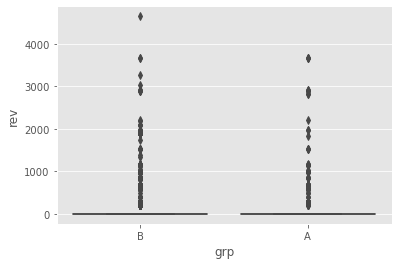

In [85]:
sns.boxplot(x='grp',y='rev', data = all_df)

In [86]:
all_df.describe()

,student_id,rev
count,7.457600e+04,74576.000000
mean,2.165617e+06,7.687808
std,2.786959e+06,110.907645
min,1.489000e+03,0.000000
25%,9.197188e+05,0.000000
50%,1.669752e+06,0.000000
75%,3.328121e+06,0.000000
max,2.010677e+08,4650.000000


##### Т.к. большинство пользователей не являются клиентами, то все значения дохода оказались выбросами. Можем сделать вывод, что распределения не являются нормальными и для оценки статистически значимых различий использовать непараметрический критерий  Манна-Утни, который переводит все значения в ранговую шкалу и уже после этого считает какой средний ранг оказался в каждой группе. Этот критерий менее чувствителен к выбросам:

In [87]:
mannwhitneyu(all_df[all_df.grp=='A'].rev,
         all_df[all_df.grp=='B'].rev)

MannwhitneyuResult(statistic=439940462.0, pvalue=0.9767852353134627)

##### Получили pvalue=0.976. Т.к. мы берем уровень альфа, равным 5%, то не можем отклонить гипотезу о том, что группы между собой не различаются.

#### Посчитаем ARPPU для каждой группы клиентов(средний доход с привлеченного клиента). Для нас это один из самых важных показателей.
###### ARPPU = доход/ количество клиентов

In [88]:
metrics['arppu'] = metrics.rev/metrics.paying_users

In [89]:
metrics

,grp,rev,paying_users,all_users,active_studs,cr,cr_active,arpu,arppu
0,A,92096.0,107,14693,1538,0.73,6.96,6.268019,860.710280
1,B,481230.0,434,59883,6803,0.72,6.38,8.036171,1108.824885


###### Проверим есть ли статистически значимые различия между группами.
###### Предположим, что разлий нет - Н0, различия есть - Н1

In [90]:
paying_df = all_df.query('rev>0')
paying_df

,student_id,grp,rev
1,1627,A,990.0
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
220,100300,B,990.0
...,...,...,...
74365,5645737,B,1900.0
74381,5651566,B,1900.0
74402,5662322,B,1900.0
74452,5681918,B,1900.0


<AxesSubplot:xlabel='grp', ylabel='rev'>

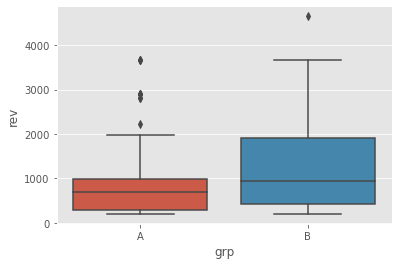

In [91]:
sns.boxplot(x='grp',y='rev', data = paying_df)

In [92]:
paying_df.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


#### Видим, что в группах есть выбросы (экстремально большие значения).
#### Проверим распределения на нормальность, предварительно убрав выбросы по 0.99 процентилю

In [93]:
paying_df = paying_df.loc[paying_df['rev'] < paying_df.rev.quantile(q=0.99)]
# отсеила выбросы

<AxesSubplot:xlabel='grp', ylabel='rev'>

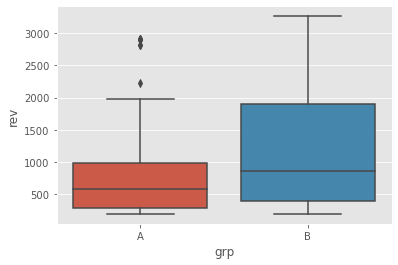

In [94]:
sns.boxplot(x='grp',y='rev', data = paying_df)
#видим, что отсеив 0.99 процентиль все выбросы убрать не удалось

##### С помощью теста Шапиро-Уилка проверим распределения на нормальность:

In [95]:
sample_test_A= paying_df.query('grp=="A"')['rev']

stats.shapiro(sample_test_A)

ShapiroResult(statistic=0.741539716720581, pvalue=3.05831358501929e-12)

In [96]:
sample_test_B= paying_df.query('grp=="B"')['rev']

stats.shapiro(sample_test_B)

ShapiroResult(statistic=0.8684478998184204, pvalue=1.2702796566041817e-18)

#### Т.к. обе выборки представляют собой не нормальные распределения (p_value < 0.05 в обоих случаях) Сравним их с помощью непараметрического аналога - U-критерия Манна-Утни, который переводит все данные в рангову шкалу и после этого считает какой средний ранг оказался в первой группе и во второй. Этот критерий менее чувствителен к выбросам:

In [97]:
mannwhitneyu(paying_df[paying_df.grp=='A'].rev,
         paying_df[paying_df.grp=='B'].rev)

MannwhitneyuResult(statistic=16566.0, pvalue=3.114365285054551e-05)

###### pvalue < 0.05  - это значит, что платящие пользователи в тестовой и контрольной группах статистически значимо различаются между собой и у нас есть основания отклонить Н0 и принять гипотезу Н1. Но предварительно перепроверим это с помощью bootstrap.

In [98]:
# объявляем функцию bootstrap

def get_bootstrap_median(
    data_column_1, # числовые значения для первой выборки
    data_column_2, # числовые значения для второй выборки
    boot_it = 2000, # количество бутстрап_подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values # True - параметр возвращения
        
        samples_2 = data_column_2.sample(boot_len, replace = True).values # True - параметр возвращения
        
        boot_data.append(statistic(samples_1 - samples_2)) # median()- применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    ci = pd_boot_data.quantile([left_quant,right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.median(boot_data),
        scale = np.std(boot_data) )
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.median(boot_data),
        scale = np.std(boot_data) )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data' : boot_data,
            'ci' : ci,
            'p_value' : p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

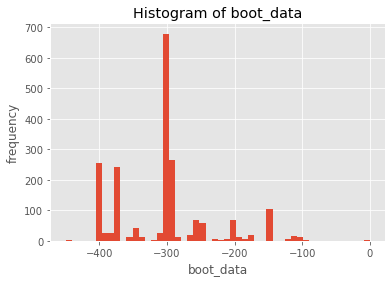

In [99]:
booted_data = get_bootstrap_median(paying_df.query('grp=="A"').rev, paying_df.query('grp=="B"').rev)

In [100]:
booted_data['p_value']

1.9185451259245357e-05

In [101]:
booted_data['ci']

,0
0.025,-400.0
0.975,-150.0


#### По проведенным выше тестам можно сделать вывод, что механика оплаты не влияет на количество активных пользователей и в обеих группах конверсии  в покупку (и абсолютная и относительная) статистически значимо между собой не отличаются, но при этом средний доход с привлеченного клиента в тестовой группе ВЫШЕ, чем в контрольной и эти различия статистически значимы. Однако, т.к. тестировали новую механику оплаты, то вероятно должно было произойти увеличение конверсии, а уже как следствие рост ARPPU.  Потому что механика оплаты по идеи не влияет на увеличение чека. 
#### Необходимо больше данных для проверки корректности сплитования. Если же сплитование, как и предполагалось произведено верно, то возможно нужно больше времени на эксперимент, чтобы получить статистически значимые различия в группах,  а так же можно провести эксперимент на бОльших выбоках.
#### Таким образом считаю, что на данном этапе не целесообразно менять механику оплаты у всех пользователей.